In [20]:
from nbapy import team, constants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
years = ['2015-16', '2016-17', '2017-18']
MAX_TEAMS: int = 44

In [3]:
def get_team_ids():
    return team.TeamList().teams()["TEAM_ID"]

In [4]:
def get_shooting_split_instance(team_id_index: int, season: str = "2017-18", won: bool = True):
    assert team_id_index <= MAX_TEAMS
    t_id = str(get_team_ids()[team_id_index])
    if won:
        return team.ShootingSplits(t_id, per_mode=constants.PerMode.PerGame, season=season, outcome="W")
    return team.ShootingSplits(t_id, per_mode=constants.PerMode.PerGame, season=season, outcome="L")

In [5]:
def get_shot_areas(s_split: team.ShootingSplits):
    return s_split.shot_areas()

In [6]:
def generate_rows(**kwargs):
    for index, row in team.TeamList().teams().iterrows():
        # print("INDEX: %s" % index)
        split = get_shooting_split_instance(index, **kwargs)
        shot_range = get_shot_areas(split)
        if shot_range.empty:
            if index == MAX_TEAMS:
                break
            # print('EMPTY')
            continue
        lc_fga = shot_range.iloc[3]["FGA"]
        lc_fgm = shot_range.iloc[3]["FGM"]

        rc_fga = shot_range.iloc[4]["FGA"]
        rc_fgm = shot_range.iloc[4]["FGM"]
        if kwargs['won']:
            outcome = 'W'
        else:
            outcome = 'L'
        row = [row["ABBREVIATION"], kwargs['season'], str(lc_fga), str(lc_fgm), str(rc_fga), str(rc_fgm), outcome]
        assert len(row) == 7
        yield row

In [7]:
def generate_dataset(**kwargs):
    data = np.array([val for val in generate_rows(**kwargs) if val is not None])
    # TODO add Game category
    return pd.DataFrame(data=data, columns=['TEAM', 'Season', 'LC3_FGA', 'LC3_FGM', 'RC3_FGA', 'RC3_FGM', 'OUTCOME'],
                        dtype=str)

In [8]:
# GENERATE WINNING GAMES DATASET
def process(won=True):
    for year in years:
        yield generate_dataset(season=year,won=won)

In [9]:
winning_df = pd.concat([val for val in process()])
losing_df = pd.concat([val for val in process(won=False)])

In [10]:
correct_types = {'LC3_FGA': 'int32', 'LC3_FGM': 'int32', 'RC3_FGA': 'int32', 'RC3_FGM': 'int32'}
winning_df = winning_df.astype(correct_types)
losing_df = losing_df.astype(correct_types)

In [11]:
print('Saving CSV Files...')
winning_df.to_csv('assets/winning_shooting_stats.csv')
losing_df.to_csv('assets/losing_shooting_stats.csv')

Saving CSV Files...


In [12]:
winning_df.info()
winning_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 0 to 29
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   TEAM     90 non-null     object
 1   Season   90 non-null     object
 2   LC3_FGA  90 non-null     int32 
 3   LC3_FGM  90 non-null     int32 
 4   RC3_FGA  90 non-null     int32 
 5   RC3_FGM  90 non-null     int32 
 6   OUTCOME  90 non-null     object
dtypes: int32(4), object(3)
memory usage: 4.2+ KB


,TEAM,Season,LC3_FGA,LC3_FGM,RC3_FGA,RC3_FGM,OUTCOME
0,TOR,2015-16,243,103,163,68,W
1,ATL,2015-16,153,56,174,68,W
2,BOS,2015-16,137,49,145,55,W
3,CLE,2015-16,220,90,252,111,W
4,NOP,2015-16,83,35,82,33,W


In [13]:
losing_df.info()
losing_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90 entries, 0 to 29
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   TEAM     90 non-null     object
 1   Season   90 non-null     object
 2   LC3_FGA  90 non-null     int32 
 3   LC3_FGM  90 non-null     int32 
 4   RC3_FGA  90 non-null     int32 
 5   RC3_FGM  90 non-null     int32 
 6   OUTCOME  90 non-null     object
dtypes: int32(4), object(3)
memory usage: 4.2+ KB


,TEAM,Season,LC3_FGA,LC3_FGM,RC3_FGA,RC3_FGM,OUTCOME
0,TOR,2015-16,95,29,77,36,L
1,ATL,2015-16,118,39,133,47,L
2,BOS,2015-16,117,47,110,27,L
3,CLE,2015-16,93,32,97,28,L
4,NOP,2015-16,151,44,141,39,L


In [26]:
winning_ave_lc3_fga = winning_df['LC3_FGA'].groupby(winning_df['TEAM']).mean()
winning_ave_lc3_fgm = winning_df['LC3_FGM'].groupby(winning_df['TEAM']).mean()
winning_ave_rc3_fga = winning_df['RC3_FGA'].groupby(winning_df['TEAM']).mean()
winning_ave_rc3_fgm = winning_df['RC3_FGM'].groupby(winning_df['TEAM']).mean()

In [27]:
losing_ave_lc3_fga = losing_df['LC3_FGA'].groupby(losing_df['TEAM']).mean()
losing_ave_lc3_fgm = losing_df['LC3_FGM'].groupby(losing_df['TEAM']).mean()
losing_ave_rc3_fga = losing_df['RC3_FGA'].groupby(losing_df['TEAM']).mean()
losing_ave_rc3_fgm = losing_df['RC3_FGM'].groupby(losing_df['TEAM']).mean()

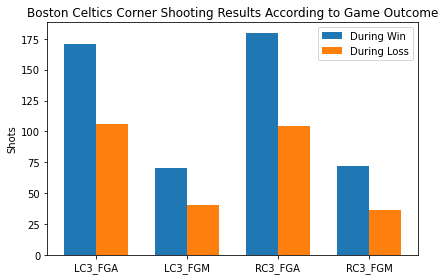

In [29]:
labels = list(winning_df.columns[2:6])
w_averages = [winning_ave_lc3_fga['BOS'], winning_ave_lc3_fgm['BOS'], winning_ave_rc3_fga['BOS'], winning_ave_rc3_fgm['BOS']]
l_averages = [losing_ave_lc3_fga['BOS'], losing_ave_lc3_fgm['BOS'], losing_ave_rc3_fga['BOS'], losing_ave_rc3_fgm['BOS']]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()

rects1 = ax.bar(x - width/2, w_averages, width, label='During Win')
rects2 = ax.bar(x + width/2, l_averages, width, label='During Loss')
ax.set_ylabel('Shots')
ax.set_title('Boston Celtics Corner Shooting Results According to Game Outcome')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
fig.tight_layout()
plt.show()